In [1]:
import numpy as np
import pandas as pd
from scipy import io
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.manifold as skman
import sklearn.decomposition as decomp
import umap
from sklearn import cluster
from sklearn import metrics


In [2]:
def myrss(data, kmeans):
    cc = kmeans.cluster_centers_
    K, M = cc.shape
    N = len(kmeans.labels_)
    dists = np.zeros((N,))
    for l in np.unique(kmeans.labels_):
        l_idx = np.where(kmeans.labels_==l)[0]
        cluster_data = data[l_idx, :]
        dist = cluster_data-cc[l, :]
        for j, i in enumerate(l_idx):
            dists[i] = np.dot(dist[j, :], dist[j, :])
    var = np.std(dists)**2
    return np.sum(dists/var)

def rss(data, kmeans):
    cc = kmeans.cluster_centers_
    K, M = cc.shape
    labels = kmeans.labels_
    error = 0
    for (xy, l) in zip(data, labels):
        d = xy-cc[l, :]
        error += np.dot(d, d)
    return error

def myic(data, kmeans):
    cc = kmeans.cluster_centers_
    K, M = cc.shape
    N = len(kmeans.labels_)
    mindists = np.zeros((N,))
    for l in np.unique(kmeans.labels_):
        l_idx = np.where(kmeans.labels_==l)[0]
        cluster_data = data[l_idx, :]
        pdist = metrics.pairwise_distances(cluster_data)
        for k in range(len(l_idx)):
            pdist[k, k] = np.nan
        mindists[l_idx] = np.nanmin(pdist, axis=0)
    var = np.std(mindists)**2
    return np.sum(np.dot(mindists, mindists))+2*K*M

def aic(data, kmeans):
    cc = kmeans.cluster_centers_
    K, M = cc.shape
    return rss(data, kmeans) + 2*K*M

def aicc(data, kmeans):
    cc = kmeans.cluster_centers_
    K, M = cc.shape
    N = len(kmeans.labels_)
    m = K*M
    return rss(data, kmeans) + 2*m + (2*m*(m+1))/(N-m-1)

def bic(data, kmeans):
    cc = kmeans.cluster_centers_
    K, M = cc.shape
    N = len(kmeans.labels_)
    return rss(data, kmeans) + np.log(N)*K*M

def dunn(data, kmeans):
    cc = kmeans.cluster_centers_
    labels = kmeans.labels_
    K, M = cc.shape
    S = np.zeros((K,))
    T = np.zeros((K,))
    for (xy, l) in zip(data, labels):
        T[l] += 1
        d = xy-cc[l, :]
        S[l] += np.sqrt(np.dot(d, d))
    for l in range(K):
        S[l] /= T[l]
    Alist = []
    for i in range(K):
        for j in range(i+1, K):
            d = cc[i, :]-cc[j,:]
            Alist.append(np.sqrt(np.dot(d, d)))
    DI = np.min(Alist)/np.max(S)
    return DI
    

def db(data, kmeans):
    cc = kmeans.cluster_centers_
    labels = kmeans.labels_
    K, M = cc.shape
    S = np.zeros((K,))
    T = np.zeros((K,))
    for (xy, l) in zip(data, labels):
        T[l] += 1
        d = xy-cc[l, :]
        S[l] += np.sqrt(np.dot(d, d))
    for l in range(K):
        S[l] /= T[l]
    R = np.zeros((K, K))
    for i in range(K):
        for j in range(i+1, K):
            d = cc[i, :]-cc[j,:]
            Aij = np.sqrt(np.dot(d, d))
            R[i, j] = (S[i]+S[j])/Aij
            R[j, i] = (S[i]+S[j])/Aij
    DB = 0
    for j in range(K):
        DB += np.max(R[j, :])
    DB = DB/K
    return DB
    

In [3]:
group1 = np.random.randn(300, 10)*0.5+1
group2 = np.random.randn(300, 10)*0.5-1
group3 = np.random.randn(300, 10)*0.5+0
testdata = np.vstack((group1, group2, group3))


N, M = testdata.shape
K = 2

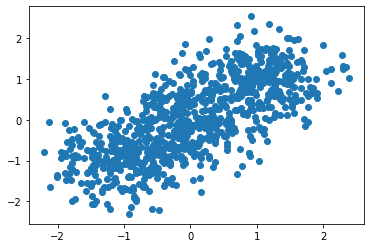

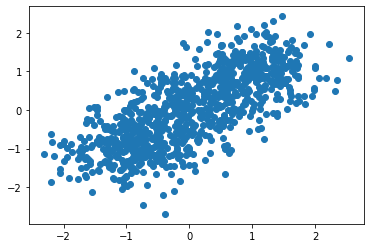

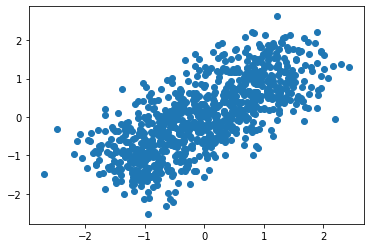

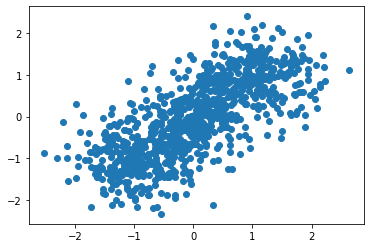

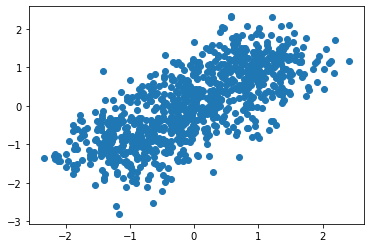

In [4]:
for i in range(6):
    plt.figure()
    plt.scatter(testdata[:, i], testdata[:, i+1])

In [5]:
fit = umap.UMAP(min_dist=1, n_neighbors=50)
u = fit.fit_transform(testdata)
u = u/np.std(u)
plt.scatter(u[:, 0], u[:, 1])

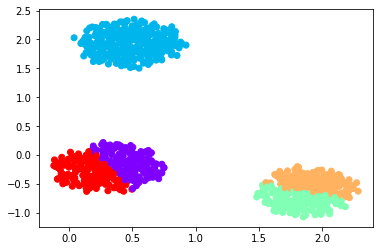

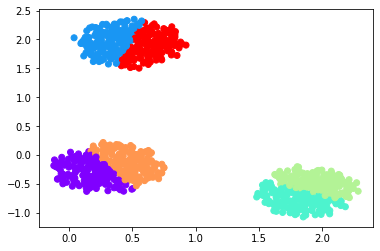

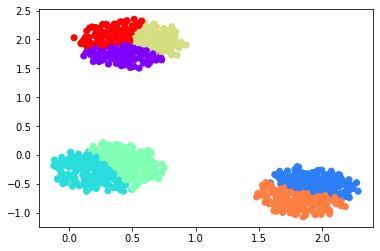

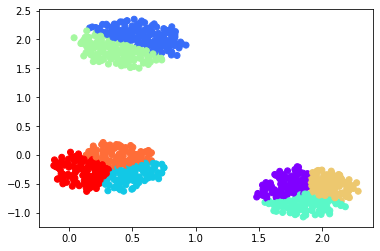

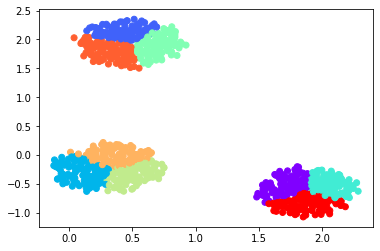

In [6]:
rslist = []
aiclist = []
aicclist = []
biclist = []
dblist = []
dilist = []
for K in range(2, 10):
    data = u
    kmeans = cluster.KMeans(n_clusters=K).fit(data)
    kmeans.labels_
    plt.figure()
    plt.scatter(u[:, 0], u[:, 1], c=kmeans.labels_, cmap='rainbow')
    rslist.append(rss(data, kmeans))
    aiclist.append(aic(data, kmeans))
    aicclist.append(aicc(data, kmeans))
    biclist.append(bic(data, kmeans))
    dblist.append(db(data, kmeans))
    dilist.append(dunn(data, kmeans))

Text(0.5, 1.0, 'Dunn Index')

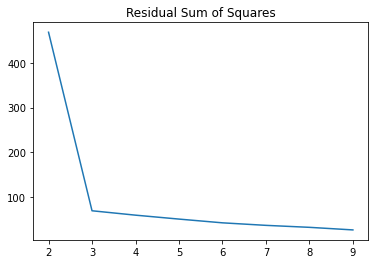

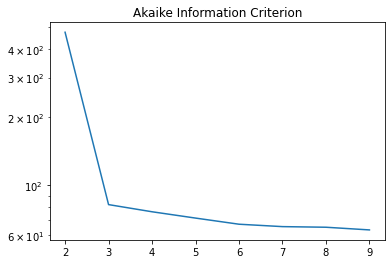

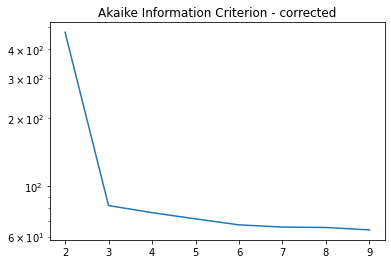

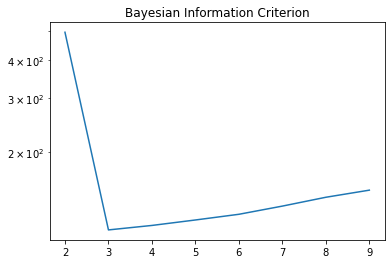

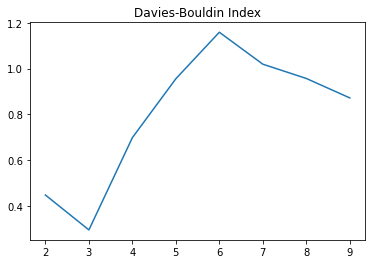

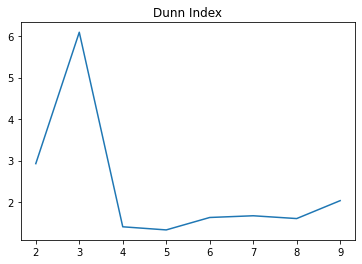

In [7]:
plt.figure()
plt.plot(list(range(2, 10)), rslist)
plt.title('Residual Sum of Squares')
plt.figure()
plt.semilogy(list(range(2, 10)), aiclist)
plt.title('Akaike Information Criterion')
plt.figure()
plt.semilogy(list(range(2, 10)), aicclist)
plt.title('Akaike Information Criterion - corrected')
plt.figure()
plt.semilogy(list(range(2, 10)), biclist)
plt.title('Bayesian Information Criterion')
plt.figure()
plt.plot(list(range(2, 10)), dblist)
plt.title('Davies-Bouldin Index')
plt.figure()
plt.plot(list(range(2, 10)), dilist)
plt.title('Dunn Index')